# Predictor levels within vs. without bounding box

In [3]:
#@title Imports

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.model_selection import train_test_split

In [4]:
# Load All Images into Dataframe
def load_image(path):
    return_img = None
    try:
        return_img = image.load_img(path)
    except:
        print("Did not find file: " + path)
    
    return return_img

def get_full_path(name):
    return str("data/trees/" + name)

img_df = pd.read_json("data/img_metadata.json", dtype={'x': float, 'y': float, 'width': float, 'height': float})
img_df["file_name"] = img_df["file_name"].map(get_full_path)


In [12]:
sick_df = img_df[img_df["classification"] == "sick"]


In [14]:

avg_rgb_in_bbox = []
avg_rgb_out_bbox = []

for index, row in sick_df.iterrows():
    file_name = row['file_name']
    x, y, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
    
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if x != -1 and y != -1 and width != -1 and height != -1:
        region_in_bbox = img[y:y + height, x:x + width]
        avg_rgb_in_bbox.append(np.mean(region_in_bbox, axis=(0, 1)))

        mask = np.ones(img.shape, dtype=bool)
        mask[y:y + height, x:x + width] = False
        region_out_bbox = img[mask].reshape(-1, 3)
        avg_rgb_out_bbox.append(np.mean(region_out_bbox, axis=0))
    else:
        avg_rgb_in_bbox.append(np.array([-1, -1, -1]))
        avg_rgb_out_bbox.append(np.mean(img, axis=(0, 1)))

print(avg_rgb_in_bbox)
print(avg_rgb_out_bbox)






[array([55.35197675, 67.71842374, 52.50176898]), array([57.26540557, 65.33123471, 53.64794901]), array([51.83906623, 61.38367672, 46.09191454]), array([43.16024431, 53.01824129, 39.417076  ]), array([58.35754906, 74.32281125, 55.08174919]), array([90.54015991, 92.6184039 , 67.06543086]), array([97.75650536, 99.7032884 , 72.2651018 ]), array([ 95.60399302, 100.75860584,  67.85962459]), array([ 95.92251276, 101.26509169,  68.09480437]), array([ 93.48996973, 101.0254464 ,  66.08288881]), array([105.14507997, 111.03351314,  73.35484431]), array([105.01886936, 110.53154379,  69.31569116]), array([90.70394835, 97.90524705, 61.11341245]), array([ 97.57643678, 102.41922414,  62.59471264]), array([100.57002174, 105.01654348,  65.24063043]), array([107.42679435, 109.08439516,  69.27997984]), array([115.67689759, 119.94225251,  87.16005671]), array([124.28549809, 128.91024634,  96.65549297]), array([128.87843107, 130.3272203 ,  96.15068867]), array([115.95608146, 122.4596527 ,  87.81445781]), arr

In [20]:
rgb_in = pd.DataFrame(avg_rgb_in_bbox)
rgb_out = pd.DataFrame(avg_rgb_out_bbox)

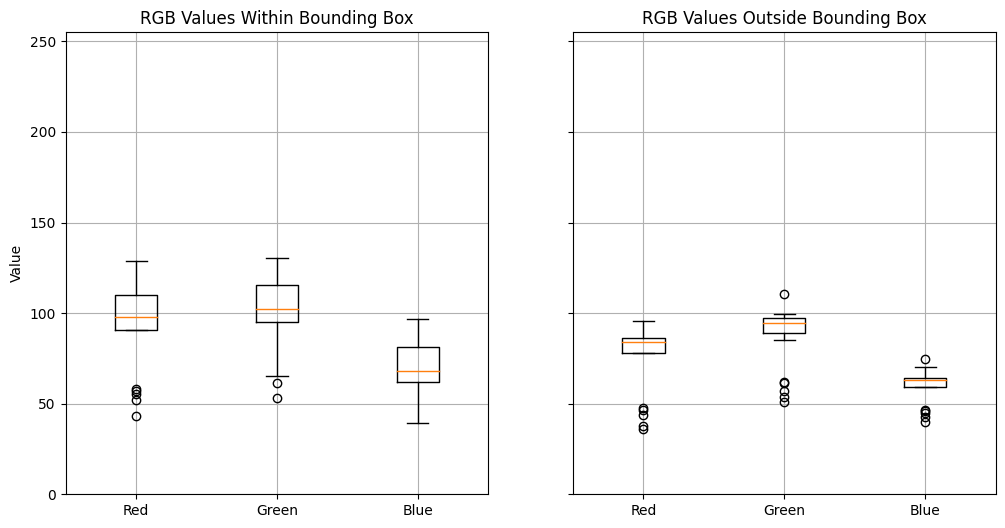

In [27]:
# Create box plots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

# Box plot for the area within the bounding box
ax1.boxplot([rgb_in[0], rgb_in[1], rgb_in[2]],
            labels=['Red', 'Green', 'Blue'])
ax1.set_title('RGB Values Within Bounding Box')
ax1.set_ylabel('Value')
ax1.set_ylim([0, 255])
ax1.grid()

ax1.boxprops

# Box plot for the area outside the bounding box
ax2.boxplot([rgb_out[0], rgb_out[1], rgb_out[2]],
            labels=['Red', 'Green', 'Blue'])
ax2.set_title('RGB Values Outside Bounding Box')
ax2.set_ylim([0, 255])
ax2.grid()

# Show the plots

plt.show()

In [39]:
in_red_val_count = np.zeros(256, int)
in_green_val_count = np.zeros(256, int)
in_blue_val_count = np.zeros(256, int)

out_red_val_count = np.zeros(256, int)
out_green_val_count = np.zeros(256, int)
out_blue_val_count = np.zeros(256, int)


for index, row in sick_df.iterrows():
    file_name = row['file_name']
    x, y, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
    
    # Read the image using OpenCV
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get the region inside the bounding box
    region_in_bbox = img[y:y + height, x:x + width]
    for img_row in region_in_bbox:
        for px in img_row:
            in_red_val_count[int(px[0])] += 1
            in_green_val_count[int(px[1])] += 1
            in_blue_val_count[int(px[2])] += 1

    # Create a mask to get the region outside the bounding box
    mask = np.ones(img.shape, dtype=bool)
    mask[y:y + height, x:x + width] = False
    region_out_bbox = img[mask].reshape(-1, 3)
    for img_row in region_out_bbox:
        for px in img_row:
            out_red_val_count[int(px[0])] += 1
            out_green_val_count[int(px[1])] += 1
            out_blue_val_count[int(px[2])] += 1

    print("Evaluated", row['file_name'])

IndexError: invalid index to scalar variable.

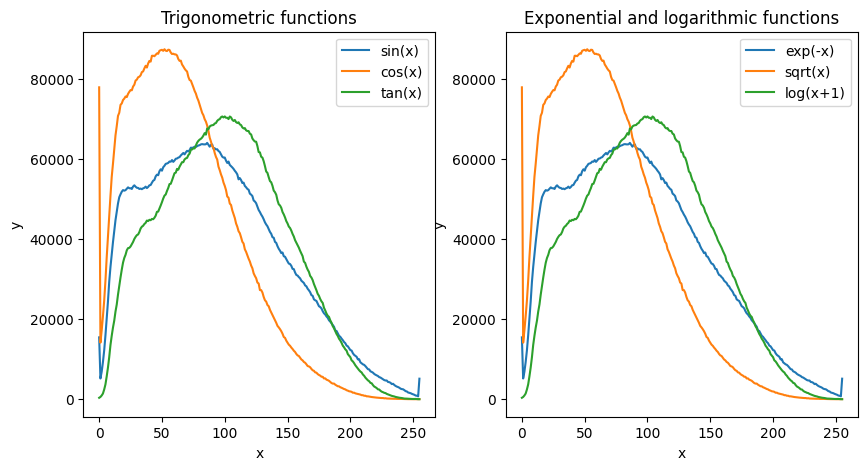

In [38]:
color_vals = range(0,256)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot
ax1.plot(color_vals, in_red_val_count, label='sin(x)')
ax1.plot(color_vals, in_blue_val_count, label='cos(x)')
ax1.plot(color_vals, in_green_val_count, label='tan(x)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Trigonometric functions')
ax1.legend()

# Plot the second subplot
ax2.plot(color_vals, out_red_val_count, label='exp(-x)')
ax2.plot(color_vals, out_blue_val_count, label='sqrt(x)')
ax2.plot(color_vals, out_green_val_count, label='log(x+1)')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Exponential and logarithmic functions')
ax2.legend()

# Display the plot
plt.show()